In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = torch.linspace(1,800,800)

# feel free to choose your own f

In [3]:
def f(t):
    return np.cos(2*np.pi*t / 1000) * np.log(t) + t / 100 + np.random.uniform(-t/10, t/10)

In [79]:
def f(t, train=True):
    return np.sin(2*np.pi*t / 30) * np.log(t) / 2 + t / 100 + np.random.uniform(-t/1000, t/1000) * train

#### 2.2 Creating a tensor `y` as a sin function of `x` <a id=4></a>

In [80]:
y = f(x)

#### 2.3 Plotting `y` <a id=5></a>

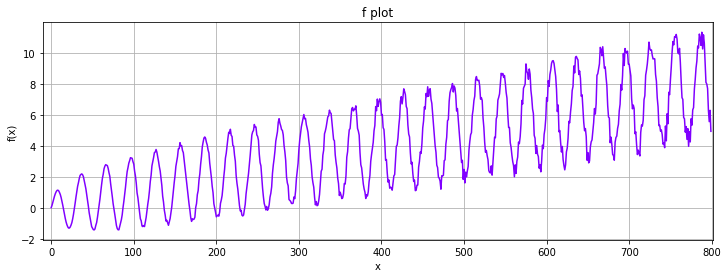

In [81]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("f plot")
plt.plot(y.numpy(),color='#8000ff')
plt.show()

### 3. Batching the data <a id=6></a>
[back to top](#100)

#### 3.1 Splitting the data in train/test set <a id=7></a>

In [82]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

##### 3.1.1 Plotting the training/testing set

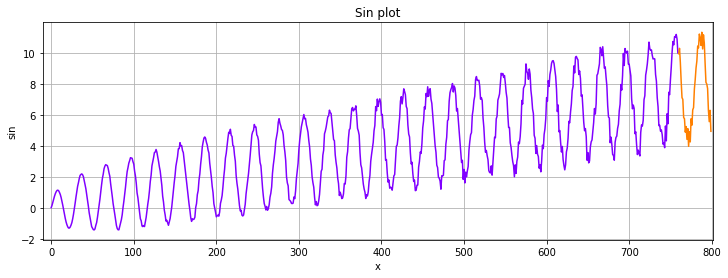

In [83]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")
plt.plot(train_set.numpy(),color='#8000ff')
plt.plot(range(760,800),test_set.numpy(),color="#ff8000")
plt.show()

#### 3.2 Creating the batches of data <a id=8></a>

While working with LSTM models, we divide the training sequence into series of overlapping windows. The label used for comparison is the next value in the sequence.

For example if we have series of of 12 records and a window size of 3, we feed [x1, x2, x3] into the model, and compare the prediction to `x4`. Then we backdrop, update parameters, and feed [x2, x3, x4] into the model and compare the prediction to `x5`. To ease this process, I'm defining a function `input_data(seq,ws)` that created a list of (seq,labels) tuples. If `ws` is the window size, then the total number of (seq,labels) tuples will be `len(series)-ws`.

In [10]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    
    return out

In [11]:
window_size = 40
train_data = input_data(train_set, window_size)
len(train_data)

660

##### 3.2.2 Checking the 1st value from train_data

In [12]:
train_data[0]

(tensor([ 0.0100,  0.2342,  0.5288,  0.8548,  1.1880,  1.5096,  1.8038,  2.0577,
          2.2602,  2.4026,  2.4784,  2.4833,  2.4154,  2.2750,  2.0649,  1.7897,
          1.4563,  1.0732,  0.6506,  0.2000, -0.2663, -0.7352, -1.1935, -1.6280,
         -2.0261, -2.3759, -2.6666, -2.8891, -3.0358, -3.1012, -3.0817, -2.9761,
         -2.7854, -2.5129, -2.1640, -1.7463, -1.2693, -0.7441, -0.1831,  0.4000]),
 tensor([0.9909]))

### 4. Defining the model <a id=9></a>
[back to top](#100)

#### 4.1 Model Class <a id=10></a>

In [13]:
class LSTM(nn.Module):
    
    def __init__(self,input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

#### 4.2 Model Instantiation <a id = 11></a>

In [14]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

##### 4.2.1 Printing the model

In [15]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

#### 4.3 Training <a id = 12></a>

During training, I'm visualising the prediction process for the test data on the go. It will give a better understanding of how the training is being carried out in each epoch. The training sequence is represented in <span style="color:#8000ff">purple</span> while the predicted sequence in represented in <span style="color:#ff8000">orange</span>.

Epoch 0 Loss: 0.3830104172229767
Performance on test range: 84.44343566894531


ValueError: x and y must have same first dimension, but have shapes (100,) and (40,)

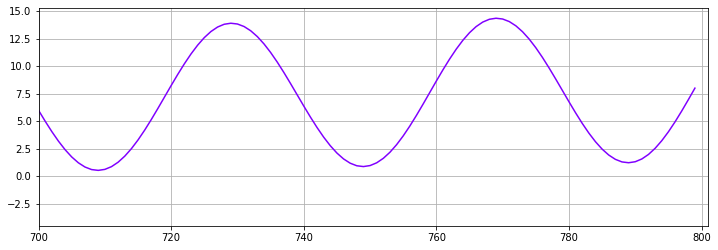

In [19]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_set[-window_size:].tolist()
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
        
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance on test range: {loss}")
    
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy(),color='#8000ff')
    plt.plot(range(760,800),preds[window_size:],color='#ff8000')
    plt.show()